## **Imports**

In [ ]:
%matplotlib inline
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import cv2
import torch   
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import lr_scheduler
import time
import copy

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU")
else: 
  device = torch.device("cpu")
  print("Running on the CPU")

Running on the GPU


In [ ]:
# declate image size
imsize = 105

In [ ]:
# Moun to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
! ls '/content/drive/My Drive/Mote_Manatee'

alldata_aug2.npy  jul27.pth	 out3.npy	paired_aug2.npy
jul23.pth	  MMLDUs_BatchA  out_jul23.npy


In [ ]:
# Read the npy files
manatee_data = np.load('/content/drive/My Drive/Mote_Manatee/alldata_aug2.npy', allow_pickle=True)
manatee_paired = np.load('/content/drive/My Drive/Mote_Manatee/paired_aug2.npy', allow_pickle=True)

Manatee_paired is all the found pairs in the dataset. Manatee_data is all the images in the dataset

In [ ]:
print('Manatee_data shape is: ', manatee_data.shape)
print('Manatee_paired data shape is: ',manatee_paired.shape)

Manatee_data shape is:  (1392, 105, 105)
Manatee_paired data shape is:  (726, 3)


In [ ]:
# Change label from index-base to 1-0

for labeled_pair in manatee_paired:
  label = labeled_pair[2].argmax()
  labeled_pair[2] = label

## Make Data


Since we need genuine pairs for testing accuracy. I will reserve 10% of genuine pairs from manatee_paired.

In [ ]:
# Reserve 10% of paired data for testing
num_points = round(manatee_paired.shape[0] * 0.1) #73
# set seed for reproducibility
np.random.seed(0)
# get 73 'random' numbers to use as indeces for manatee_paired data
indices = np.random.choice(manatee_paired.shape[0], num_points, replace=False)
test_paired = manatee_paired[indices]
test_paired.shape


(73, 3)

In [ ]:
# get the remaining indices
indices_to_remove = indices
train_paired = np.delete(manatee_paired, indices_to_remove, axis=0)
train_paired.shape

(653, 3)

Now that the genuine pairs and all the images are available. I created this class to make the train-val dataset. The dataset will be a numpy array with each element being [img1, img2, label]. This dataset will include genuine and impostor pairs.

Note: make_dataset() will always return all the imporstor pairs followed by all the genuine pairs. It is important to shuffle the data once it has been created.

In [ ]:
class MakeTrainValData():
  """
  This class is meant to make the train-val dataset by pairing impostor pairs and incorporating genuine pairs.
  """
  def __init__(self, train_paired, all_data):
    self.train_paired = train_paired
    self.all_data = all_data

  def make_dataset(self, pairs_per_image):
    data = []

    # make different pairs
    for img in self.all_data:
      img1 = img
      for i in range(pairs_per_image):
        random = np.random.randint(0, self.all_data.shape[0])
        img2 = self.all_data[random]
        label = 0

        data.append([img1, img2, label])

    # add labeled pairs
    for labeled_pair in self.train_paired:
      data.append(labeled_pair)

    return np.asarray(data)

In [ ]:
data = MakeTrainValData(train_paired, manatee_data)
data = data.make_dataset(1)
print(f'Dataset has been created, with {data.shape[0]} labeled pairs')

Dataset has been created, with 2045 labeled pairs


In [ ]:
# IMPORTANT! Shuffle dataset
np.random.seed(10)
shuffled_data = np.random.permutation(data)
shuffled_data.shape

(2045, 3)

## Separate train-val-test sets

In [ ]:
val_num = round(shuffled_data.shape[0] * 0.1)
train_num = round(shuffled_data.shape[0] * 0.9)
print(f'Training data points: {train_num}')
print(f'Validation data points: {val_num}')

Training data points: 1840
Validation data points: 204


In [ ]:
###### GET TRAINING/VAL DATA POINTS

# set seed for reproducibility
np.random.seed(0)
# get train_num 'random' numbers to use as indeces for shuffled_data
indices = np.random.choice(shuffled_data.shape[0], train_num, replace=False)
train_data = shuffled_data[indices]
print(f'train_data shape is: {train_data.shape}')

# drop train indices from shuffled_data, which are the val_data points
indices_to_remove = indices
val_data = np.delete(shuffled_data, indices_to_remove, axis=0)
print(f'val_data shape is: {val_data.shape}')

train_data shape is: (1840, 3)
val_data shape is: (205, 3)


## Compute mean and std for Training Data

In [ ]:
class TrainDataNormalize(Dataset):
  def __init__(self, train_data, imsize=105, compute_mean_std=None):
    self.train_data = train_data
    self.imsize = imsize
    self.compute_mean_std = compute_mean_std

  def __len__(self):
    return self.train_data.shape[0]

  def __getitem__(self, idx):
    x1 = torch.Tensor(self.train_data[idx][0]).view(-1, self.imsize, self.imsize)
    x2 = torch.Tensor(self.train_data[idx][1]).view(-1, self.imsize, self.imsize)
    y = torch.Tensor([self.train_data[idx][2]])

    if self.compute_mean_std:
      return x1/255.0,x2/255.0
    else:
      return x1/255.0, x2/255.0, y

In [ ]:
train_data_compute = TrainDataNormalize(train_data, compute_mean_std=True)

We need to manually implement the formulas for the mean and stantard deviation and iterate over small batches of the dataset.

source: https://deeplizard.com/learn/video/lu7TCu7HeYc

In [ ]:
# First, we create a data loader with a small batch size
loader = DataLoader(train_data_compute, batch_size=1000, num_workers=1)

# Then, we calculate our n value or total number of pixels
num_of_pixels = train_num * 105 * 105   #Note that 105*105 is the height and width of the images in the dataset

# Now we sum the pixel values by iterating over each batch,
# and we calculate the mean by dividing this sum by the total num of pixels
total_sum = 0
for batch in loader: total_sum += batch[0].sum()
mean = total_sum/num_of_pixels

# Next we calculate the sum of the squared errors by iterating
# through each batch. This allows us to calculate st by dividing
# the sum of the squared errors by the total number of pixels and 
# square rooting the result

sum_of_squared_error = 0
for batch in loader:
  sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()
std = torch.sqrt(sum_of_squared_error / num_of_pixels)


print(f'mean is {mean}, std is {std}')

mean is 0.9760749936103821, std is 0.12026530504226685


In [ ]:
mean = 0.9760749936103821
std = 0.12026530504226685

# **Dataset class loader**

In [ ]:
class TrainValDataset(Dataset):
  """ Manatee Dataset Class """

  def __init__(self, manatee_data, imsize, transform=None):
    """
    Args: 
        manatee_data (np array): numpy structured as (x1,x2,y)
        transform (optional): optional transform to be applied on a sample
    """
    self.manatee_data = manatee_data
    self.transform = transform
    self.imsize = imsize
    #self.mean = mean 
    #self.std = std

  def __len__(self):
    return self.manatee_data.shape[0]

  def __getitem__(self, idx):
    #x1 = torch.Tensor(self.manatee_data[idx][0]).view(-1, self.imsize, self.imsize)
    #x2 = torch.Tensor(self.manatee_data[idx][1]).view(-1, self.imsize, self.imsize)
    y = torch.Tensor([self.manatee_data[idx][2]])
    x1 = self.manatee_data[idx][0]
    x2 = self.manatee_data[idx][1]

    if self.transform:
      pil_x1 = Image.fromarray(x1, mode='1')
      pil_x2 = Image.fromarray(x2, mode='1')
      x1 = self.transform(pil_x1)
      x2 = self.transform(pil_x2)

    return x1, x2, y

In [ ]:
train_data_class = TrainValDataset(train_data, 105, transform=transforms.Compose([transforms.ToTensor(),
                                                                                  transforms.Normalize([mean], [std])]))

In [ ]:
# Train data class example:
#train_data_class.__getitem__(0)

In [ ]:
val_data_class = TrainValDataset(val_data, 105, transform=transforms.Compose([transforms.ToTensor(),
                                                                                  transforms.Normalize([mean], [std])]))

In [ ]:
# Val data class example:
#val_data_class.__getitem__(0)

# **Neural Net Definition**

In [ ]:
class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),    # 128@42*42
            nn.MaxPool2d(2),   # 128@21*21
            nn.Conv2d(128, 128, 4),
            nn.ReLU(), # 128@18*18
            nn.MaxPool2d(2), # 128@9*9
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),   # 256@6*6
        )
        self.linear = nn.Sequential(nn.Linear(9216, 4096)) #512 out
        #self.dropout = nn.Dropout(0.5)
        self.out = nn.Sequential(nn.Linear(4096, 1), nn.Sigmoid())

    def forward2(self, x1, x2):
      out1 = self.forward_one(x1)
      out2 = self.forward_one(x2)
      #L2_distance = torch.nn.PairwiseDistance(p=2, keepdim = True)
      #distance = L2_distance(out1, out2)
      #out = self.out(distance)
      cos = nn.CosineSimilarity(eps=1e-6)
      # similarity metric CV SDM
      out = cos(out1,out2)
      return out

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        out = self.linear(x)
        #output = self.dropout(out)
        return out

    def forward(self, input1, input2):
        out1 = self.forward_one(input1)
        out2 = self.forward_one(input2)
        L1_distance = torch.abs(out1 - out2)
        output = self.out(L1_distance)
        return output

In [ ]:
net = Siamese()
# push to device
net = net.to(device)
print(sum(p.numel() for p in net.parameters()))

38951745


## Alternative Loss Function (Contrastive Loss)



In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, p=1, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

class ContrastiveLoss2(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss2, self).__init__()
        self.margin = 0.2
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

Margin in contrastive loss is more like regulirization constraint it defines hypersphere radius where all similar samples should locate .So from this point of view learning the margin will lead to overtraining “ bias-variance problem”. 

You can just normalize features using L2 before using Contrastive Loss. Then the margin can be constant while training because the distance between features will be normalized. You can of course change margin in dynamic way, but I do not think it will gain any boost. Idea from A Unified Embedding for Face Recognition and Clustering (although they use Triplet Loss, the same idea can be used in Siamese Network)

## Forward pass test example

In [ ]:
train_loader_tst = DataLoader(train_data_class, batch_size=1, shuffle=True, num_workers=1)
net_tst = Siamese()

for x1, x2, label in train_loader_tst:
  out = net_tst(x1,x2)
  print(out)
  loss = nn.functional.binary_cross_entropy(out, label)
  print(loss)
  break


tensor([[0.4994]], grad_fn=<SigmoidBackward>)
tensor(0.6943, grad_fn=<BinaryCrossEntropyBackward>)


# **Train**

In [ ]:
#Create DataLoader iterators
train_loader = DataLoader(train_data_class, batch_size=64, shuffle=True, num_workers=2) 
val_loader = DataLoader(val_data_class, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
dataloaders = {'train': train_loader, 'val':val_loader}
dataset_sizes = {'train': train_data.shape[0], 'val': val_data.shape[0]}

In [ ]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1.0
    #best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            #running_corrects = 0

            # Iterate over data.
            for x1,x2,y in dataloaders[phase]:
                x1 = x1.to(device)
                x2 = x2.to(device)
                y = y.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # net.forward()
                    preds = model(x1,x2)
                    # compute loss
                    #loss = criterion(out1,out2, y)
                    loss = torch.nn.functional.binary_cross_entropy(preds, y)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * x1.size(0)
                #running_corrects += torch.sum(preds == y)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss)) #epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#! pip install torch-lr-finder
from torch_lr_finder import LRFinder

model = Siamese()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
#lr_finder.reset()

ModuleNotFoundError: ignored

In [ ]:
optimizer = optim.Adam(net.parameters(), lr = 0.00005, weight_decay=1e-2) #lr = 0.00006)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
# train and evaluate
model = train_model(net, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6713
val Loss: 0.6343

Epoch 1/9
----------
train Loss: 0.6034
val Loss: 0.5517

Epoch 2/9
----------
train Loss: 0.5208
val Loss: 0.4600

Epoch 3/9
----------
train Loss: 0.4377
val Loss: 0.3829

Epoch 4/9
----------
train Loss: 0.3953
val Loss: 0.3765

Epoch 5/9
----------
train Loss: 0.3889
val Loss: 0.3708

Epoch 6/9
----------
train Loss: 0.3830
val Loss: 0.3652

Epoch 7/9
----------
train Loss: 0.3774
val Loss: 0.3600

Epoch 8/9
----------
train Loss: 0.3719
val Loss: 0.3545

Epoch 9/9
----------
train Loss: 0.3667
val Loss: 0.3496

Training complete in 1m 42s
Best val loss: 0.349634


## **Test Trained Network**

- Look for architecture (first)
- Bayesian optimization 
- data augmentation
- lr finder
- weight decay and L2 (optimizer)
- check Adam vs SGD with momentum with warm restarts (after lr finder)



### Make Supportive set for test accuracy

In [ ]:

def make_set(size, genpair):
  """ 
  This function will make sets for testing accuracy. Each set will include (size) impostor images plus a genuine pair.
  (genpair) is the index of genuine pair in test_paired data.
  """
  supportive_set_id = np.random.randint(low=0, high=manatee_data.shape[0], size=size)
  # genuine pair
  x1,x2 = test_paired[genpair][:2]
  # support set
  ss = manatee_data[supportive_set_id]
  # combine genuine pair and support set
  Set = [x1,x2]
  for i in ss:
    Set.append(i)
  return Set, supportive_set_id

Set1, supportive_set_id = make_set(20,2)

In [ ]:
def preprocess(img):
  """ 
  This function will preprocess a raw nparray image to a normalized torch tensor with batch dimension added
  """
  # perform trasformations (normalize, scale)
  pil_im = Image.fromarray(img, mode='1')
  preprocess = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize([mean], [std])
                                 ])
  preprocessed_im = preprocess(pil_im)
  # add batch dimension
  im = torch.unsqueeze(preprocessed_im, 0)
  return im


In [ ]:
# Compute similarity between anchor im and every other img in the Set
def compute_sim(Set):
  anchor = Set[0]
  prep_anchor = preprocess(anchor)
  prep_anchor = prep_anchor.to(device)
  ss = Set[1:]
  out_list = []
  for img in ss:
    prep_im = preprocess(img)
    prep_im = prep_im.to(device)
    with torch.no_grad():
      out = model(prep_anchor, prep_im)
    out_list.append(out)
  return out_list

In [192]:
out = compute_sim(Set1)
out_np = np.array(out)
out_np.argmax()

print(out_np)

[tensor([[0.4370]], device='cuda:0') tensor([[0.3845]], device='cuda:0')
 tensor([[0.1664]], device='cuda:0') tensor([[0.3036]], device='cuda:0')
 tensor([[0.1870]], device='cuda:0') tensor([[0.5198]], device='cuda:0')
 tensor([[0.2590]], device='cuda:0') tensor([[0.3635]], device='cuda:0')
 tensor([[0.1664]], device='cuda:0') tensor([[0.2590]], device='cuda:0')
 tensor([[0.5048]], device='cuda:0') tensor([[0.3407]], device='cuda:0')
 tensor([[0.1706]], device='cuda:0') tensor([[0.4527]], device='cuda:0')
 tensor([[0.4617]], device='cuda:0') tensor([[0.4542]], device='cuda:0')
 tensor([[0.1870]], device='cuda:0') tensor([[0.5070]], device='cuda:0')
 tensor([[0.4245]], device='cuda:0') tensor([[0.2590]], device='cuda:0')
 tensor([[0.1754]], device='cuda:0')]


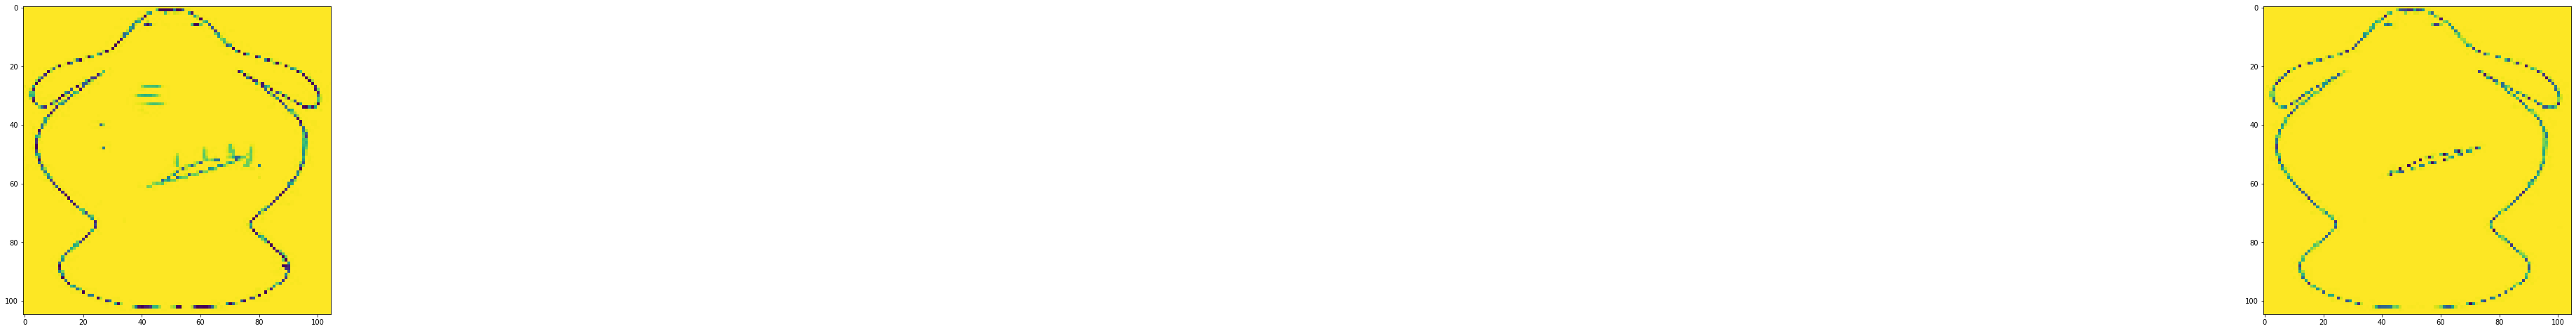

In [ ]:
x1,x2 = test_paired[2][:2]
genuine_pair = [x1,x2]

plt.figure(figsize=(105,105))
columns = 2
for i, image in enumerate(genuine_pair):
  plt.subplot(len(sup_set) / columns + 1, columns, i + 1)
  plt.imshow(image)

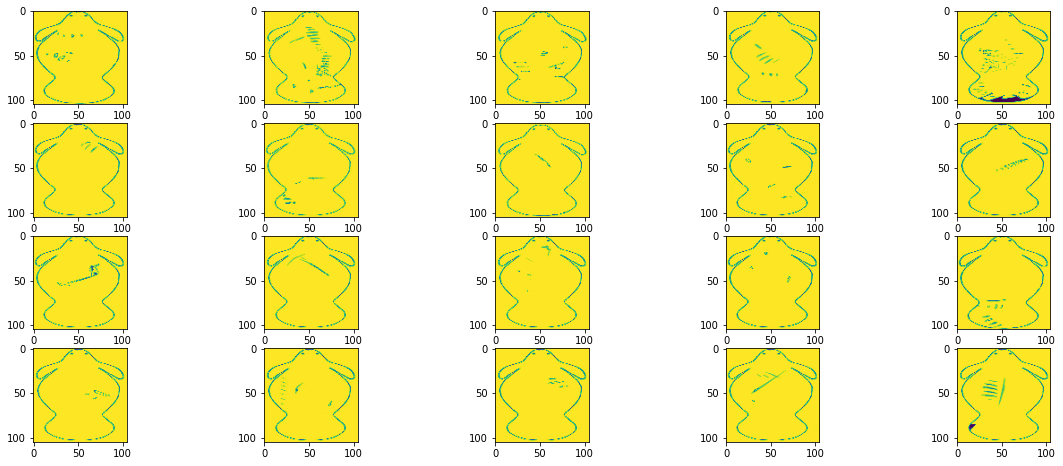

In [ ]:
from IPython.display import display 
%matplotlib inline 

sup_set = manatee_data[supportive_set_id]

plt.figure(figsize=(20,10))
columns = 5
for i, image,score in enumerate(sup_set):
  plt.subplot(len(sup_set) / columns + 1, columns, i + 1)
  plt.imshow(image)

In [205]:
num_correct = 0
# 72 is the number of genuine pairs in test set
for i in range(72):
  Set,_ = make_set(10,i)
  out_list = compute_sim(Set)
  set_np = np.array(out_list)
  if set_np.argmax() == 0:
    num_correct += 1

print(num_correct)

55


In [206]:
print(f'Accuracy for test set is {num_correct/72}')

Accuracy for test set is 0.7638888888888888
